#### Import Libraries

In [51]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=Warning)
sns.set()

#### Import Data

In [36]:
ticker = "NXTG"
start_date = "2024-04-01"
end_date = "2025-03-31"

data = yf.download(ticker, start=start_date, end=end_date)
data = data.asfreq("D").dropna()

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NXTG,NXTG,NXTG,NXTG,NXTG
Date,,,,,
2024-04-01,77.792976,78.196657,77.724055,77.891435,7400.0
2024-04-02,77.172676,77.261294,76.965912,77.261294,7600.0
2024-04-03,77.487747,77.605901,76.680378,76.680378,5400.0
2024-04-04,76.552383,78.108048,76.552383,77.871739,8200.0
2024-04-05,76.828064,77.024988,76.384999,76.414535,5800.0


In [37]:
# Use "Close" column
model_data = data[["Close", "Volume"]].rename(columns={"Ticker":"Price"})
model_data.head()

Price,Close,Volume
Ticker,NXTG,NXTG
Date,,
2024-04-01,77.792976,7400.0
2024-04-02,77.172676,7600.0
2024-04-03,77.487747,5400.0
2024-04-04,76.552383,8200.0
2024-04-05,76.828064,5800.0


#### Visualize Data

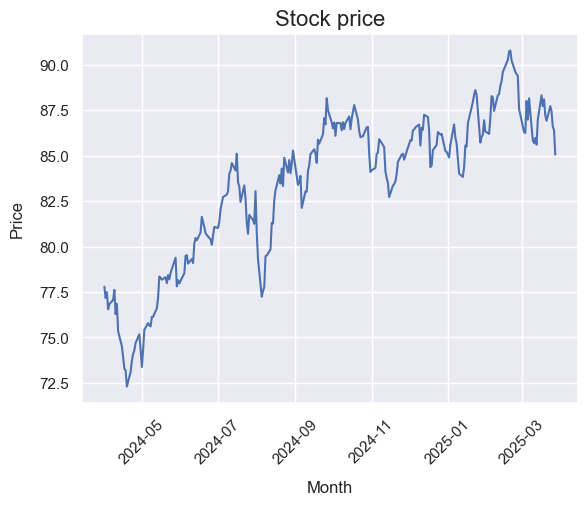

In [38]:
# Visualize stock price
plt.plot(model_data["Close"])
plt.title("Stock price", fontsize=16)
plt.xlabel("Month", labelpad=10)
plt.xticks(rotation=45)
plt.ylabel("Price", labelpad=10)
plt.show()

#### Transform Data

In [39]:
# Transforming so frequency can be set to "day"
model_data_tf = model_data.copy()
model_data_tf.index = pd.DatetimeIndex(model_data_tf.index).to_period('D')

#### Determine model parameters

In [22]:
# Import libraries
from statsmodels.tsa.stattools import adfuller

In [41]:
# Test for stationarity
adf_test = adfuller(model_data_tf["Close"].diff().dropna())
#adf_test = adfuller(model_data_tf["Close"])
print("Test Statistic", adf_test[0])
print("p-value", adf_test[1])

Test Statistic -8.823272548195321
p-value 1.8524740688291112e-14


In [25]:
# Import Libraries to plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

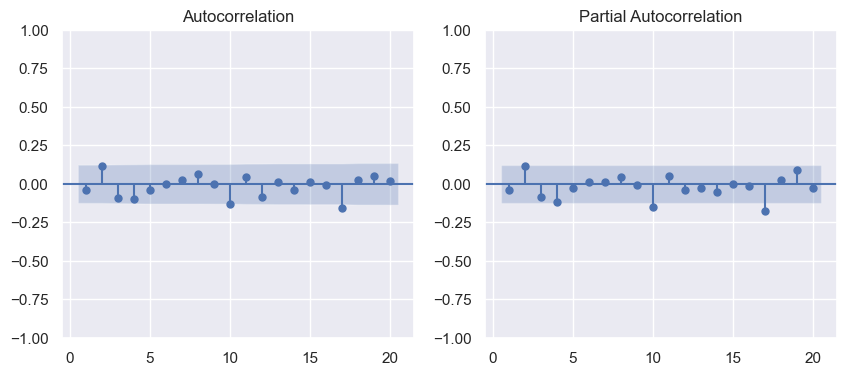

In [42]:
# Plot ACF, PACF
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

plot_acf(model_data_tf["Close"].diff().dropna(), zero=False, lags=20, ax=ax1)
plot_pacf(model_data_tf["Close"].diff().dropna(), zero=False, lags=20, ax=ax2)
plt.show()

In [28]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [53]:
# Determine p and q based on lowest AIC and BIC values
loop_results = []

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(model_data_tf["Close"], order=(p,1,q))
            results = model.fit()
            model_outputs = [p, q, results.aic, results.bic]
            loop_results.append(model_outputs)
        except:
            print(p, q, None, None)

AIC_BIC = pd.DataFrame(loop_results, columns=["p", "q", "AIC", "BIC"])

AIC_BIC.sort_values(by="AIC")

,p,q,AIC,BIC
8,2,2,575.889155,593.476419
2,0,2,586.167458,596.719816
0,0,0,586.549925,590.067378
6,2,0,586.820440,597.372799
5,1,2,587.320326,601.390138
7,2,1,588.181389,602.251201
3,1,0,588.197746,595.232652
1,0,1,588.263437,595.298342
4,1,1,589.876909,600.429268


#### Model Run

In [56]:
# Fit based on above findings
model = ARIMA(model_data_tf["Close"], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NXTG   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -291.938
Date:                Wed, 02 Apr 2025   AIC                            589.877
Time:                        17:36:23   BIC                            600.429
Sample:                    04-01-2024   HQIC                           594.124
                         - 03-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9901      0.045    -21.938      0.000      -1.079      -0.902
ma.L1          0.9997      0.484      2.065      0.039       0.051       1.949
sigma2         0.6090      0.275      2.211      0.027       0.069       1.149
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                19.09
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.59
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

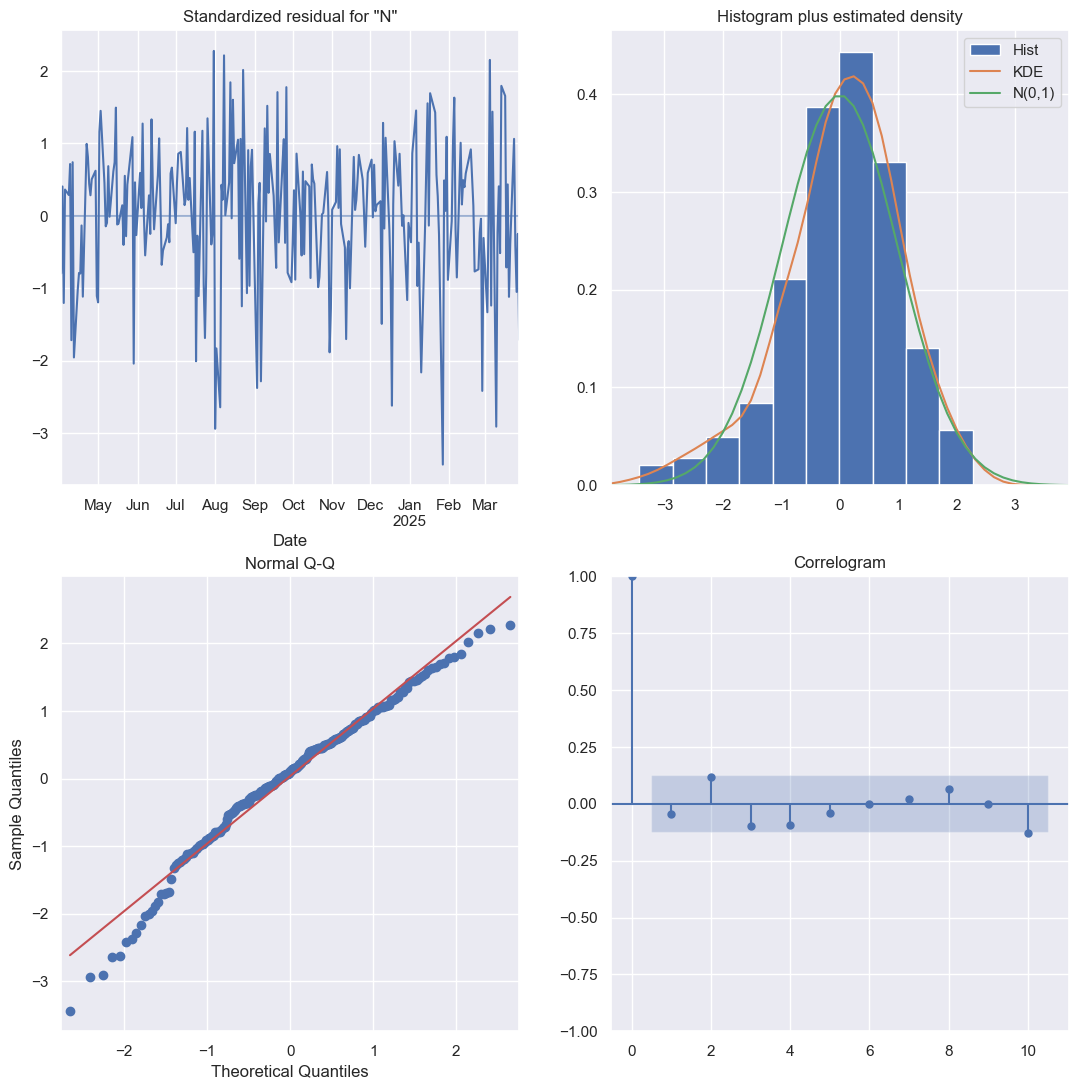

In [57]:
# Model Diagnostics
results.plot_diagnostics(figsize=(13,13))
plt.show()

#### Predictions

In [58]:
# Predictions
forecast = results.get_prediction(start=-10, dynamic=True)

# Predicted mean
forecast_mean = forecast.predicted_mean

# Confidence intervals of predictions
ci = forecast.conf_int()

# Lower, upper limits
lower_limits = ci.iloc[:, 0]
upper_limits = ci.iloc[:, 1]

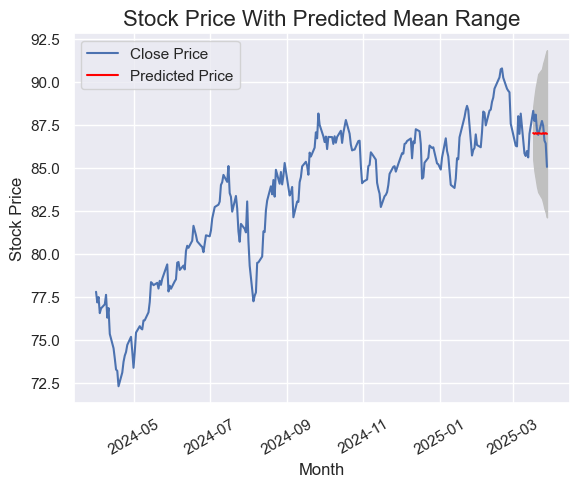

In [59]:
# Make forecasted mean values in dataframe
forecast_mean_df = pd.DataFrame(forecast_mean)

# Plot predictions
plt.plot(model_data.index, model_data["Close"], label="Close Price")
plt.plot(forecast_mean_df.index, forecast_mean_df["predicted_mean"], label="Predicted Price", color="red")
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color="silver")

plt.title("Stock Price With Predicted Mean Range", fontsize=16)
plt.xlabel("Month")
plt.xticks(rotation=30)
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#### Model Evaluation